# Model Selection

The goal of this notebook is to compare algorithms in predicting the changes in the number of residential units under FAIR Plan policy and, as a secondary target, the total exposure acquired by the program.

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_style('whitegrid')
pd.options.display.float_format = '{:.5f}'.format

CLEAN_DATA_DIR = Path('clean_data/')

In [157]:
df = pd.read_csv(CLEAN_DATA_DIR / 'engineered_dataset.csv', index_col=0)
df.sample(3)

,FAIR Plan Units,% FAIR Plan Units,Total Exposure ($),% Change - Claims (Fire and Smoke),% Change - Earned Premiums,% Change - Expiring Policies,% Change - Losses (Fire and Smoke),% Change - New Policies,% Change - Nonrenewed Policies,% Change - Nonrenewed Policies (by Company),...,Growth in Losses to All Disasters 10yr Ratio,Growth in Losses to Fire Disasters 3yr Ratio,Growth in Losses to Fire Disasters 5yr Ratio,Growth in Losses to Fire Disasters 10yr Ratio,Premium to Exposure Ratio,Nonrenewal Rate,Loss Burden per Unit,Loss Burden per Exposure,Premium Adequacy,Renewal Resilience
ZIP Code,,,,,,,,,,,,,,,,,,,,,
94112,33.00000,0.00193,15537953.00000,0.73913,0.26371,0.01541,2.80985,0.18867,0.24481,0.23810,...,0.93662,1.40492,1.40492,0.93662,4464.17499,0.08599,733.47743,733.47743,6.08632,0.91401
90043,690.00000,0.06559,269200641.00000,0.32353,0.29033,0.02824,2.63034,-0.04049,0.02692,-0.08300,...,0.87678,1.31517,1.31517,0.87678,3736.39943,0.09966,698.21217,698.21217,5.35138,0.90034
93022,51.00000,0.02599,52656220.00000,-0.70833,0.59349,0.01399,0.45952,0.58511,0.63978,1.57407,...,0.15317,0.22976,0.22976,0.15317,3975.89755,0.11734,749.74159,749.74159,5.30302,0.88266


## Train-test split

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
df_train, df_test = train_test_split(
    df,
    test_size=.2,
    random_state=13348,
    shuffle=True
)

## Evaluation metrics

We will use mean squared error (MSE) as our main evaluation metric, but we will also compute RMSE and MAE. 

For model predicting total exposure, we also will include an additional metric called 'global_difference'. This metric calculates, in USD, the absolute difference between the predicted total exposure and the actual one.

In [160]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, root_mean_squared_error as rmse

eval = pd.DataFrame(columns=['mse', 'rmse', 'mae', 'global_diff'])

In [161]:
def calculate_diff(y_true, preds):
    return round(abs((sum(y_true)-sum(preds)) / (1000 * 1000)), 2)

def calculate_metrics(y_true, preds, fix_pct=True):
# hack to set to zero percentages below 0 for unbounded regressors
    if fix_pct:
        preds = np.where(np.array(preds) < 0, 0, preds)

    return [mse(y_true, preds), 
            rmse(y_true, preds), 
            mae(y_true, preds), 
            calculate_diff(y_true, preds),
            sum(y_true) / (1000 * 1000)]

def create_eval_table(vals):
    cols = ['Feature Set', 'Target Variable' ,'Model', 'MSE', 'RMSE', 'MAE', 'Global Diff', 'Total Val']
    res = pd.DataFrame(vals, columns=cols)
    return res.groupby(['Feature Set', 'Target Variable' ,'Model']).mean()    

def plot_metrics(eval_table, feature_set, metrics=['RMSE', 'MAE']):
    eval_table.loc[feature_set].droplevel(0).plot.bar(y=metrics, rot=0, width=.8, figsize=(8,3))

    plt.xlabel(None)
    plt.title(f'Model Comparison\n (Feature set: {feature_set})')
    
    plt.show()

## Feature Selections

Based on our EDA, we selected a series of feature sets to train and benchmark our models, which is described below.

In [162]:
# use the format
# 'feature_set_name': (target, [features]) 
targets = df.columns[:3] #['FAIR Plan Units', '% FAIR Plan Units', 'Total Exposure ($)']
all_features = df.columns[3:]

main_features = ['Renewal Resilience', 'Median Gross Rent ($)',
                'Avg Median Income', 'Zillow Mean Home Value ($)',
                'Fire Disasters 1y', 'Growth in Losses to All Disasters 5yr Ratio',
                'Premium to Exposure Ratio', 'Avg % White-only Pop',
                'Nonrenewal Rate', '% Change - Earned Premiums']
main_features = ['Renewal Resilience', 
                'Avg Median Income', 
                'Zillow Mean Home Value ($)',
                'Growth in Losses to All Disasters 5yr Ratio',
                'Premium to Exposure Ratio',
                '% Change - Earned Premiums']

exposure_features = ['Zillow Mean Home Value ($)',
                    'Median Owner Cost ($)', 'Premium to Exposure Ratio',
                    'Nonrenewal Rate', '% Change - Earned Premiums']

# Rates of Change
dynamic_features = ['% Change - Claims (Fire and Smoke)',
                    '% Change - Earned Premiums',
                    '% Change - Losses (Fire and Smoke)',
                    '% Change - Zillow Home Value',
                    '% Change Median Income',
                    'All Disasters 5y']

feature_sets = {
    'main_n_fair': (targets[0], main_features),
    'main_%_fair': (targets[1], main_features),
    'main_exposure': (targets[2], main_features),    
    'exposure_features': (targets[2], exposure_features),    
    'dynamic_%_fair': (targets[1], dynamic_features)
}


## Model Specification

In [163]:
# baseline model with the mean
def baseline_model(y_train, y_test):
    mu_y = y_train.mean()
    preds = [mu_y] * len(y_test)
    return calculate_metrics(y_test, preds)

In [164]:
# linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [165]:
# knn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=4))
])

# function to find the best K for a given training set
def best_k(y_train, y_test, X_train, X_test, k_upper=20, plot=True):
    rmses = []
    for k in range(1, k_upper):
        knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        
        # fitting and prediction
        knn_pipe.fit(X_train, y_train)
        preds = knn_pipe.predict(X_test)

        # calculating and saving mse
        rmses.append((k, mse(y_test, preds)))

    # plot graph        
    if plot:
        plt.figure(figsize=(6,4))

        plt.plot(np.array(rmses)[:, 0], np.array(rmses)[:, 1])

        plt.ylabel('MSE')
        plt.xlabel('k')

        plt.show()

    best_k = rmses[int(np.where(np.array(rmses)[:, 1] == np.array(rmses)[:, 1].min())[0])][0]
    return best_k


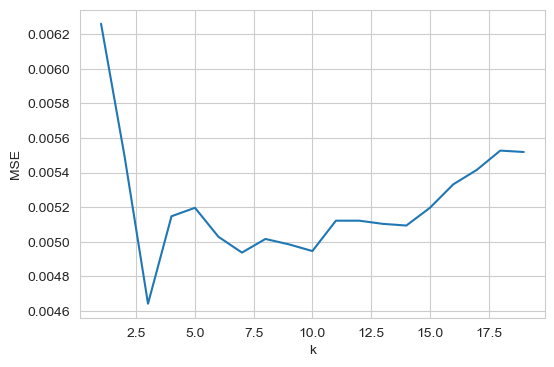

C:\Users\lbarleta\AppData\Local\Temp\ipykernel_6416\3612865308.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_k = rmses[int(np.where(np.array(rmses)[:, 1] == np.array(rmses)[:, 1].min())[0])][0]


3

In [166]:
# for feature set 'main_%_fair'
feature_set = feature_sets['main_%_fair']

y_train, y_test = df_train[feature_set[0]], df_test[feature_set[0]]
X_train, X_test = df_train[feature_set[1]], df_test[feature_set[1]]

best_k(y_train, y_test, X_train, X_test)

In [167]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

grad_bost = GradientBoostingRegressor(
    learning_rate=.1,
    n_estimators=200,
    max_depth=1
)

In [168]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(
    learning_rate=.1,
    n_estimators=200,
    max_depth=1
)

## Cross-validation

In [169]:
from sklearn.model_selection import KFold

models = [('Baseline (mean)', None),
          ('Linear Regression', lr), 
          ('kNN - 4', knn), 
          ('Gradient Boosting', grad_bost), 
          ('XGBoost', xgboost)]

kfold = KFold(n_splits = 5)

In [170]:
# function to run cross-validation in different feature sets
def run_cross_val(target, features, set=None):
    results = []

    for i, (train_index, test_index) in enumerate(kfold.split(df_train)):
        df_tt = df_train.iloc[train_index]
        df_ho = df_train.iloc[test_index]

        for j, model in enumerate(models):
            if model[0] == 'Baseline (mean)':
                eval = baseline_model(df_tt[target], df_ho[target])
            else:
                model[1].fit(df_tt[features], df_tt[target])
                preds = model[1].predict(df_ho[features])
                eval = calculate_metrics(df_ho[target], preds)

            results.append([set, target, model[0]] + eval)

    return results

In [150]:
# running cross-validation for all feature sets
vals = []

for feature_set, data in feature_sets.items():
    target = data[0]
    features = data[1]

    vals += run_cross_val(target, features, feature_set)

In [151]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
eval_table = create_eval_table(vals)

# making it into millions of dollars\n",
millions = eval_table.loc[(['exposure_features', 'main_exposure']), ['RMSE', 'MAE']] / (1000 * 1000)
eval_table.loc[(['exposure_features', 'main_exposure']), ['RMSE', 'MAE']]  = millions

cols = ['Feature Set', 'Target Variable' ,'Model', 'MSE', 'RMSE', 'MAE', 'Global Diff', 'Total Val']
res = pd.DataFrame(vals, columns=cols)

# percentage of different in exposure predictions

eval_table['Pct Diff'] = eval_table['Global Diff'] / eval_table['Total Val']

eval_table

MSE  \
Feature Set       Target Variable    Model                                      
dynamic_%_fair    % FAIR Plan Units  Baseline (mean)                    0.010   
                                     Gradient Boosting                  0.005   
                                     Linear Regression                  0.006   
                                     XGBoost                            0.005   
                                     kNN - 4                            0.005   
exposure_features Total Exposure ($) Baseline (mean)   150420645315451296.000   
                                     Gradient Boosting 130505613424775264.000   
                                     Linear Regression 115950853062742608.000   
                                     XGBoost           111353886867038368.000   
                                     kNN - 4           102803714784903296.000   
main_%_fair       % FAIR Plan Units  Baseline (mean)                    0.010   
                                     Gradient Boosting                  0.004   
                                     Linear Regression                  0.004   
                                     XGBoost                            0.003   
                                     kNN - 4                            0.003   
main_exposure     Total Exposure ($) Baseline (mean)   150420645315451296.000   
                                     Gradient Boosting 132126786305976544.000   
                                     Linear Regression 112863804836712192.000   
                                     XGBoost           111924590065491040.000   
                                     kNN - 4           116817458678524128.000   
main_n_fair       FAIR Plan Units    Baseline (mean)               209516.771   
                                     Gradient Boosting             150258.731   
                                     Linear Regression             164731.191   
                                     XGBoost                       134937.263   
                                     kNN - 4                       155877.827   

                                                          RMSE     MAE  \
Feature Set       Target Variable    Model                               
dynamic_%_fair    % FAIR Plan Units  Baseline (mean)     0.098   0.057   
                                     Gradient Boosting   0.070   0.037   
                                     Linear Regression   0.074   0.042   
                                     XGBoost             0.068   0.037   
                                     kNN - 4             0.071   0.037   
exposure_features Total Exposure ($) Baseline (mean)   373.936 170.673   
                                     Gradient Boosting 348.899 145.264   
                                     Linear Regression 327.050 154.457   
                                     XGBoost           323.597 143.414   
                                     kNN - 4           305.248 128.010   
main_%_fair       % FAIR Plan Units  Baseline (mean)     0.098   0.057   
                                     Gradient Boosting   0.058   0.030   
                                     Linear Regression   0.063   0.039   
                                     XGBoost             0.055   0.029   
                                     kNN - 4             0.056   0.027   
main_exposure     Total Exposure ($) Baseline (mean)   373.936 170.673   
                                     Gradient Boosting 352.966 142.697   
                                     Linear Regression 322.625 153.018   
                                     XGBoost           324.577 141.788   
                                     kNN - 4           328.921 136.226   
main_n_fair       FAIR Plan Units    Baseline (mean)   451.798 222.706   
                                     Gradient Boosting 383.971 172.743   
                                     Linear Regression 398.395 203.170   
                                    

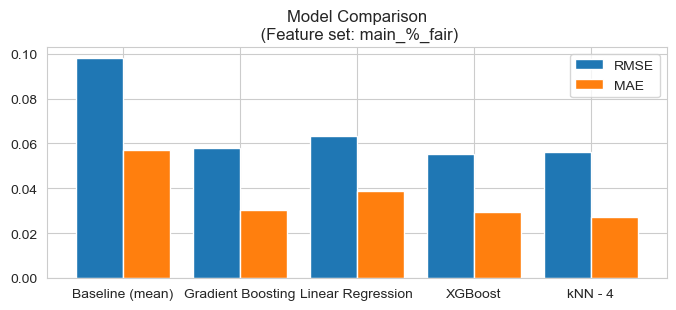

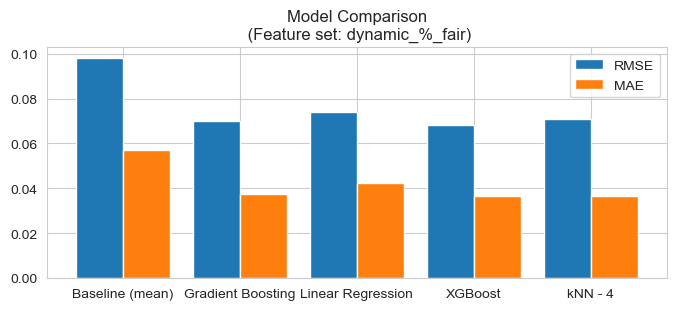

In [193]:
plot_metrics(eval_table, 'main_%_fair')
plot_metrics(eval_table, 'dynamic_%_fair')

## Comparing to Classification Algorithms (and their probability) 

An issue we encountered with our model is to that out target variable is a percentage. Most regressors, however, are not bounded at (0,1) and can potentially predict data outside this range. A possible solution is to adapt classification algorithms that generate probabilities and use them as our predictors. Based on Steven Gubkin's implementation of an AggregatedClassifierWrapper, we compare our best regressors to a Logistic Regression classifier.

In [194]:
from AggregatedClassifierWrapper import AggregatedClassifierWrapper
from sklearn.linear_model import LogisticRegression

features = feature_sets['main_%_fair'][1] 
target = '% FAIR Plan Units'             # already a proportion (0 to 1)
population_col = 'Total Res Units'       # ZIP code population count

X_train, X_test = df_train[features], df_test[features]
pop_train, pop_test = df_train[population_col], df_test[population_col]
pct_train, pct_test = df_train[target], df_test[target]

In [195]:
# scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# fitting model
clf = AggregatedClassifierWrapper(LogisticRegression(solver='lbfgs', max_iter=1000))
clf.fit(X_train_scaled, pop_train, pct_train)

# predicting probabilities of class 1 (i.e., FAIR Plan)
probs = clf.predict_proba(X_test_scaled)[:, 1]

# evaluation
mets = calculate_metrics(pct_test.values, probs)

print(f"MSE for Log Reg: {mets[0]}")
print(f"RMSE for Log Reg: {mets[1]}")
print(f"MAE for Log Reg: {mets[2]}")

MSE for Log Reg: 0.006485440605193002
RMSE for Log Reg: 0.08053223333046838
MAE for Log Reg: 0.037626531645157155


## Final Validation

The model that performed best was the feature set "main_%_fair" using gradient boosting and XGBoost. Now let's retrain the model in the entire training data and perform final validation on the test set.

In [196]:
# the winner 
feature_set =  feature_sets['main_%_fair']

y_train, y_test = df_train[feature_set[0]], df_test[feature_set[0]]
X_train, X_test = df_train[feature_set[1]], df_test[feature_set[1]]

In [197]:
grad_bost.fit(X_train, y_train)
preds = grad_bost.predict(X_test)

xgboost.fit(X_train, y_train)
preds2 = xgboost.predict(X_test)


res = pd.DataFrame({
        'baseline_model': baseline_model(y_train, y_test),
        'grad_bost': calculate_metrics(y_test, preds),
        'xgboost': calculate_metrics(y_test, preds2),

    }).T.iloc[:, :-2].rename({0: 'MSE', 1: 'RMSE', 2: 'MAE'}, axis=1)

res

,MSE,RMSE,MAE
baseline_model,0.01515,0.12310,0.06437
grad_bost,0.00456,0.06753,0.03395
xgboost,0.00479,0.06921,0.03501


Gradient boosting is generalizing better!

## Generating predictions

In [191]:
preds = grad_bost.predict(df[feature_set[1]])

pd.DataFrame({
    'ZIP Code': df.index,
    'True Value': df[feature_set[0]],
    'Predictions (GB)': preds
}).to_csv(CLEAN_DATA_DIR / 'best_predictions.csv')